<a href="https://colab.research.google.com/github/rej156/Dissertation/blob/master/SAE_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import gensim

# Load the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Prepare the data
X = newsgroups.data
y = newsgroups.target

# Vectorize the text data
vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.95, stop_words='english')
# Use newsgroups.data instead of texts
X = vectorizer.fit_transform(newsgroups.data).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement SAE
class SparseAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, l1_reg=0.01):
        super(SparseAutoencoder, self).__init__()
        self.encoder = tf.keras.layers.Dense(hidden_dim, activation='relu',
                                             activity_regularizer=tf.keras.regularizers.l1(l1_reg))
        self.decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, inputs):
        return self.encoder(inputs)

# Train SAE
sae = SparseAutoencoder(input_dim=5000, hidden_dim=100)
sae.compile(optimizer='adam', loss='binary_crossentropy')
sae.fit(X_train, X_train, epochs=50, batch_size=256, validation_split=0.1)

# Get SAE representations
sae_repr_train = sae.encode(X_train).numpy()
sae_repr_test = sae.encode(X_test).numpy()

# Train LDA
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=100, random_state=42, max_iter=50, learning_method='online')
lda_repr_train = lda.fit_transform(X_train)
lda_repr_test = lda.transform(X_test)



Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - loss: 7.0912 - val_loss: 0.7540
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 1.1369 - val_loss: 0.7093
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.6426 - val_loss: 0.6806
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.6159 - val_loss: 0.6558
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.5931 - val_loss: 0.6336
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.5717 - val_loss: 0.6129
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.5513 - val_loss: 0.5932
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.5319 - val_loss: 0.5743
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.5133 - val_loss: 0.5562
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.4955 - val_loss: 0.5389
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.4783 - val_loss: 0.5224
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - lo

In [34]:
def compute_coherence(model, term_frequency_matrix, feature_names, texts, epsilon=1e-12):
    """
    Computes the coherence score for a topic model.

    Modified to handle both LDA models and SAE weights.
    If the model is an LDA model, it uses the components_ attribute to get the topics.
    If the model is an SAE, it uses the weights of the encoder layer to get the topics.
    """
    if hasattr(model, 'components_'):  # Check if it's an LDA model
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-10 - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append(top_features)
    else:  # Assume it's an SAE
        topics = []
        # Convert the EagerTensor to a NumPy array
        model_np = model.numpy()
        for topic_idx in range(model_np.shape[1]):  # Iterate over hidden units (topics)
            # Use argsort on the NumPy array
            top_features_ind = model_np[:, topic_idx].argsort()[:-10 - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append(top_features)

    # Tokenize texts
    tokenized_texts = [text.split() for text in texts]

    # Create Dictionary
    id2word = Dictionary(tokenized_texts)

    # Convert topics to token IDs
    topics_token_ids = [[id2word.token2id.get(word, -1) for word in topic] for topic in topics]
    # Remove words not in the dictionary
    topics_token_ids = [[token_id for token_id in topic if token_id != -1] for topic in topics_token_ids]

    # Compute coherence for each topic separately
    coherence_scores = []
    for topic in topics_token_ids:
        try:
            cm = CoherenceModel(topics=[topic], texts=tokenized_texts, dictionary=id2word, coherence='c_v')
            coherence_scores.append(cm.get_coherence())
        except (ZeroDivisionError, ValueError) as e:
            print(f"Warning: Error in coherence computation for a topic: {e}")

    # Return mean coherence if we have valid scores, otherwise return NaN
    return np.mean(coherence_scores) if coherence_scores else np.nan

def compute_sparsity(representations, threshold=1e-5):
  return np.mean(np.abs(representations) < threshold)

def classify_documents(train_repr, test_repr, y_train, y_test):
  clf = MultinomialNB()
  clf.fit(train_repr, y_train)
  return clf.score(test_repr, y_test)



SAE Coherence: 0.3867
LDA Coherence: 0.4146
SAE Sparsity: 0.9996
LDA Sparsity: 0.8679
SAE Classification Accuracy: 0.0448
LDA Classification Accuracy: 0.4886


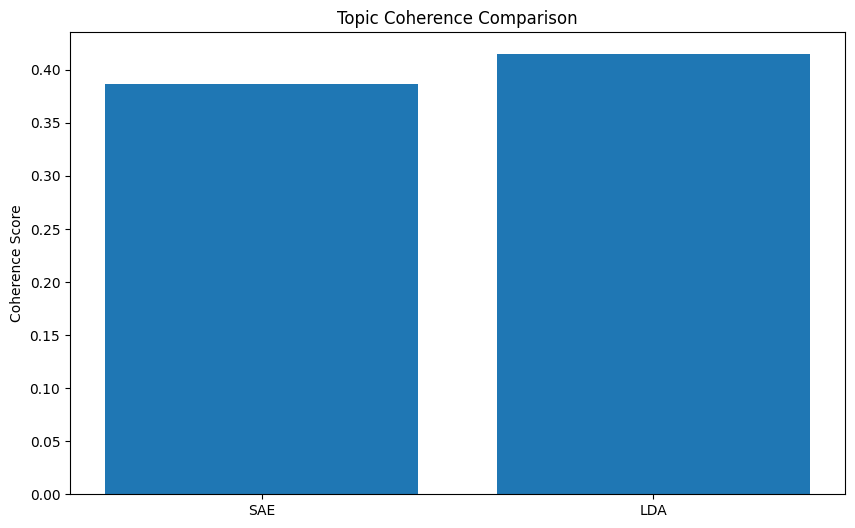

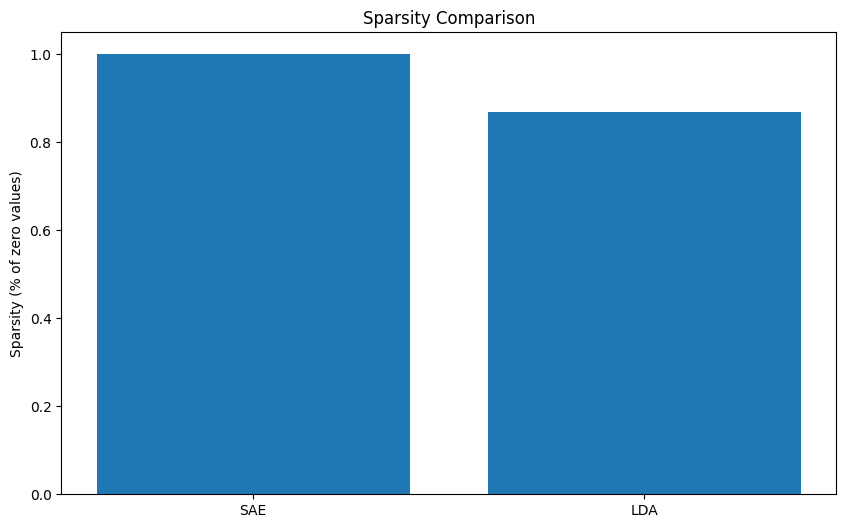

In [39]:
# Compute coherence
sae_coherence = compute_coherence(sae.encoder.weights[0], X_train, vectorizer.get_feature_names_out(), newsgroups.data)
lda_coherence = compute_coherence(lda, X_train, vectorizer.get_feature_names_out(), newsgroups.data)

# Compute sparsity
sae_sparsity = compute_sparsity(sae_repr_train)
lda_sparsity = compute_sparsity(lda_repr_train, threshold=0.01)

# Document classification
sae_accuracy = classify_documents(sae_repr_train, sae_repr_test, y_train, y_test)
lda_accuracy = classify_documents(lda_repr_train, lda_repr_test, y_train, y_test)

# Print results
print(f"SAE Coherence: {sae_coherence:.4f}")
print(f"LDA Coherence: {lda_coherence:.4f}")
print(f"SAE Sparsity: {sae_sparsity:.4f}")
print(f"LDA Sparsity: {lda_sparsity:.4f}")
print(f"SAE Classification Accuracy: {sae_accuracy:.4f}")
print(f"LDA Classification Accuracy: {lda_accuracy:.4f}")

# Generate plots
plt.figure(figsize=(10, 6))
plt.bar(['SAE', 'LDA'], [sae_coherence, lda_coherence])
plt.title('Topic Coherence Comparison')
plt.ylabel('Coherence Score')
plt.show(block=False)
plt.savefig('topic_coherence.pdf')
plt.close()

plt.figure(figsize=(10, 6))
plt.bar(['SAE', 'LDA'], [sae_sparsity, lda_sparsity])
plt.title('Sparsity Comparison')
plt.ylabel('Sparsity (% of zero values)')
plt.show(block=False)
plt.savefig('sparsity_comparison.pdf')
plt.close()